# Tema 10: HHL

En este notebook vamos a implementar el algoritmo HHL (Harrow-Hassidim-Lloyd) para resolver sistemas de ecuaciones lineales de la forma $A\vec{x}=\vec{b}$, donde $A$ es una matriz hermítica y $\vec{b}$ es un vector conocido. El objetivo es encontrar el vector solución $\vec{x}$.

El algoritmo HHL es uno de los algoritmos cuánticos más importantes porque demuestra una aceleración exponencial sobre los métodos clásicos en ciertos casos. Utiliza tres componentes principales:

1. **Preparación del estado**: Codificamos el vector $\vec{b}$ en un estado cuántico
2. **Estimación de fase cuántica (QPE)**: Extraemos los autovalores de la matriz $A$
3. **Rotación controlada**: Invertimos los autovalores mediante rotaciones condicionales
4. **QPE inversa**: Deshacemos la estimación de fase

Trabajaremos con diferentes matrices $A$ y vectores $\vec{b}$ para explorar el comportamiento del algoritmo en distintos escenarios.

El circuito cuántico general del algoritmo HHL es el siguiente:

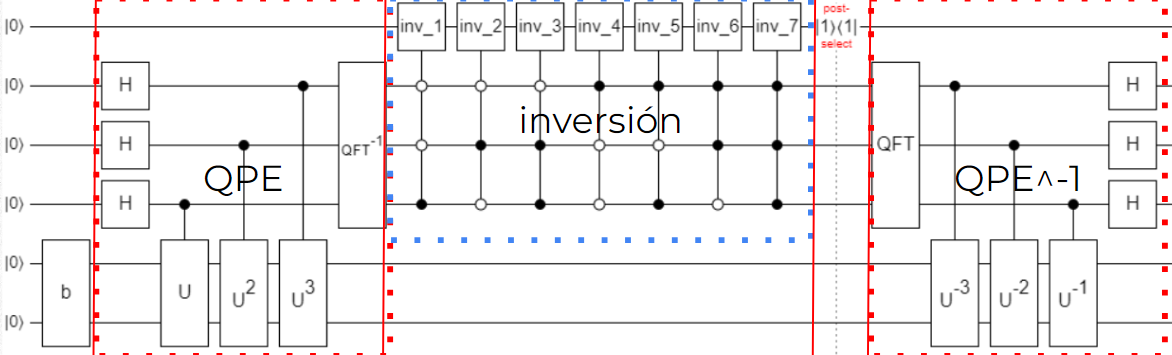

## Desarrollo teórico del algoritmo HHL

El algoritmo HHL resuelve el sistema lineal $A\vec{x} = \vec{b}$ mediante los siguientes pasos:

**1. Preparación del estado inicial**

Codificamos el vector $\vec{b}$ normalizado en un estado cuántico:
$$|b\rangle = \sum_{i=0}^{N-1} b_i |i\rangle$$

**2. Estimación de fase cuántica (QPE)**

Aplicamos QPE usando la matriz unitaria $U = e^{iAt}$ donde $t$ es el tiempo de evolución. Si $A$ tiene descomposición espectral $A = \sum_j \lambda_j |u_j\rangle\langle u_j|$, entonces:
$$|b\rangle = \sum_j \beta_j |u_j\rangle$$

Después de QPE obtenemos:
$$\sum_j \beta_j |\tilde{\lambda}_j\rangle |u_j\rangle$$

donde $|\tilde{\lambda}_j\rangle$ es la aproximación binaria del autovalor $\lambda_j$ codificada en $m$ qubits clock.

**3. Rotación controlada**

Aplicamos una rotación condicional en un qubit auxiliar que depende de los autovalores:
$$\sum_j \beta_j |\tilde{\lambda}_j\rangle |u_j\rangle \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}_j^2}}|0\rangle + \frac{C}{\tilde{\lambda}_j}|1\rangle\right)$$

donde $C$ es una constante de normalización.

**4. QPE inversa**

Deshacemos la estimación de fase para obtener:
$$\sum_j \beta_j |u_j\rangle \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}_j^2}}|0\rangle + \frac{C}{\tilde{\lambda}_j}|1\rangle\right)$$

**5. Medición y post-selección**

Al medir el qubit auxiliar y obtener $|1\rangle$, el estado colapsa a:
$$|x\rangle \propto \sum_j \frac{\beta_j}{\tilde{\lambda}_j} |u_j\rangle = \sum_j \frac{\beta_j}{\lambda_j} |u_j\rangle$$

que es proporcional a la solución $A^{-1}|b\rangle$.

La probabilidad de éxito es $P_{éxito} = \frac{C^2}{\|\vec{x}\|^2}$, donde $\|\vec{x}\|$ es la norma de la solución.

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.linalg import expm

---
# Circuito cuántico

Para el circuito cuántico tendremos que introducir el vector b y la matriz A. También incluiremos los parámetros del número m de qubits clock en la QPE, el valor de la evolución temporal t y el valor de C para la rotación. Lo prepararemos solo para matrices hermíticas (no consideramos el caso no hermítico).

In [2]:
from qiskit.circuit.library import phase_estimation, UnitaryGate, RYGate

In [3]:
def HHL_circuit(m:int, b:np.array, A:np.array, t:float, C:float):
    #Determinar el número de qubits para el estado
    n = int(np.ceil(np.log2(len(b))))

    #Ajustamos el vector b
    b_ajust = np.append(b, np.zeros(2**n-len(b)))
    A_ajust = np.eye(2**n)#Las filas y columnas añadidas tienen que ser identidad
    for i, A_i in enumerate(A):
        for j, A_ij in enumerate(A_i):
            A_ajust[i][j] = A_ij

    #Determinamos las matrices U y su puerta
    U = expm(1j*A_ajust*t)
    U_gate = UnitaryGate(U, label='U') #Creamos una puerta en base a una matriz

    #Registros
    qr = QuantumRegister(n, 'State')
    clock = QuantumRegister(m, 'Clock')
    ancilla = QuantumRegister(1, 'Anc')

    #Circuito
    qc = QuantumCircuit(ancilla, clock, qr, name='QPE')

    #Iniciamos el vector
    qc.initialize(b_ajust, qr, normalize=True)
    qc.barrier()

    #Aplicamos la QPE
    qc.append(phase_estimation(m,U_gate), clock[:]+qr[:])
    qc.barrier()

    #Vamos aplicando de manera controlada las puertas
    for lambda_i in range(1,2**m//2):#Autovalores positivos
        theta = 2*np.arcsin(C/lambda_i)
        #Para seleccionar los controles adecuados, vamos a poner X cuanto haya 0
        binario = bin(lambda_i)[2:]
        binario = ('0'*(m-len(binario)) + binario) #Añadimos 0 iniciales
        for j, bit in enumerate(binario):
            if bit == '0': qc.x(j+1)#+1 por el ancilla
        qc.append(RYGate(theta).control(m), clock[:]+ancilla[:])
        for j, bit in enumerate(binario):#Deshacemos
            if bit == '0': qc.x(j+1)#+1 por el ancilla

    for lambda_i in range(2**m//2, 2**m):#Autovalores negativos
        theta = 2*np.arcsin(-C/(2**m - lambda_i))
        #Para seleccionar los controles adecuados, vamos a poner X cuanto haya 0
        binario = bin(lambda_i)[2:]
        binario = ('0'*(m-len(binario)) + binario) #Añadimos 0 iniciales
        for j, bit in enumerate(binario):
            if bit == '0': qc.x(j+1)
        qc.append(RYGate(theta).control(m), clock[:]+ancilla[:])
        for j, bit in enumerate(binario):#Deshacemos
            if bit == '0': qc.x(j+1)

    qc.barrier()

    #QPE inversa
    qc.append(phase_estimation(m,U_gate).inverse(), clock[:]+qr[:])

    #Tenemos que descomponer la QPE para evitar errores
    qc_desc = qc.decompose(['QPE', 'QPE_dg'], reps=2)

    return qc_desc

Creamos un vector b y una matriz A hermítica para probar y vemos el circuito obtenido.

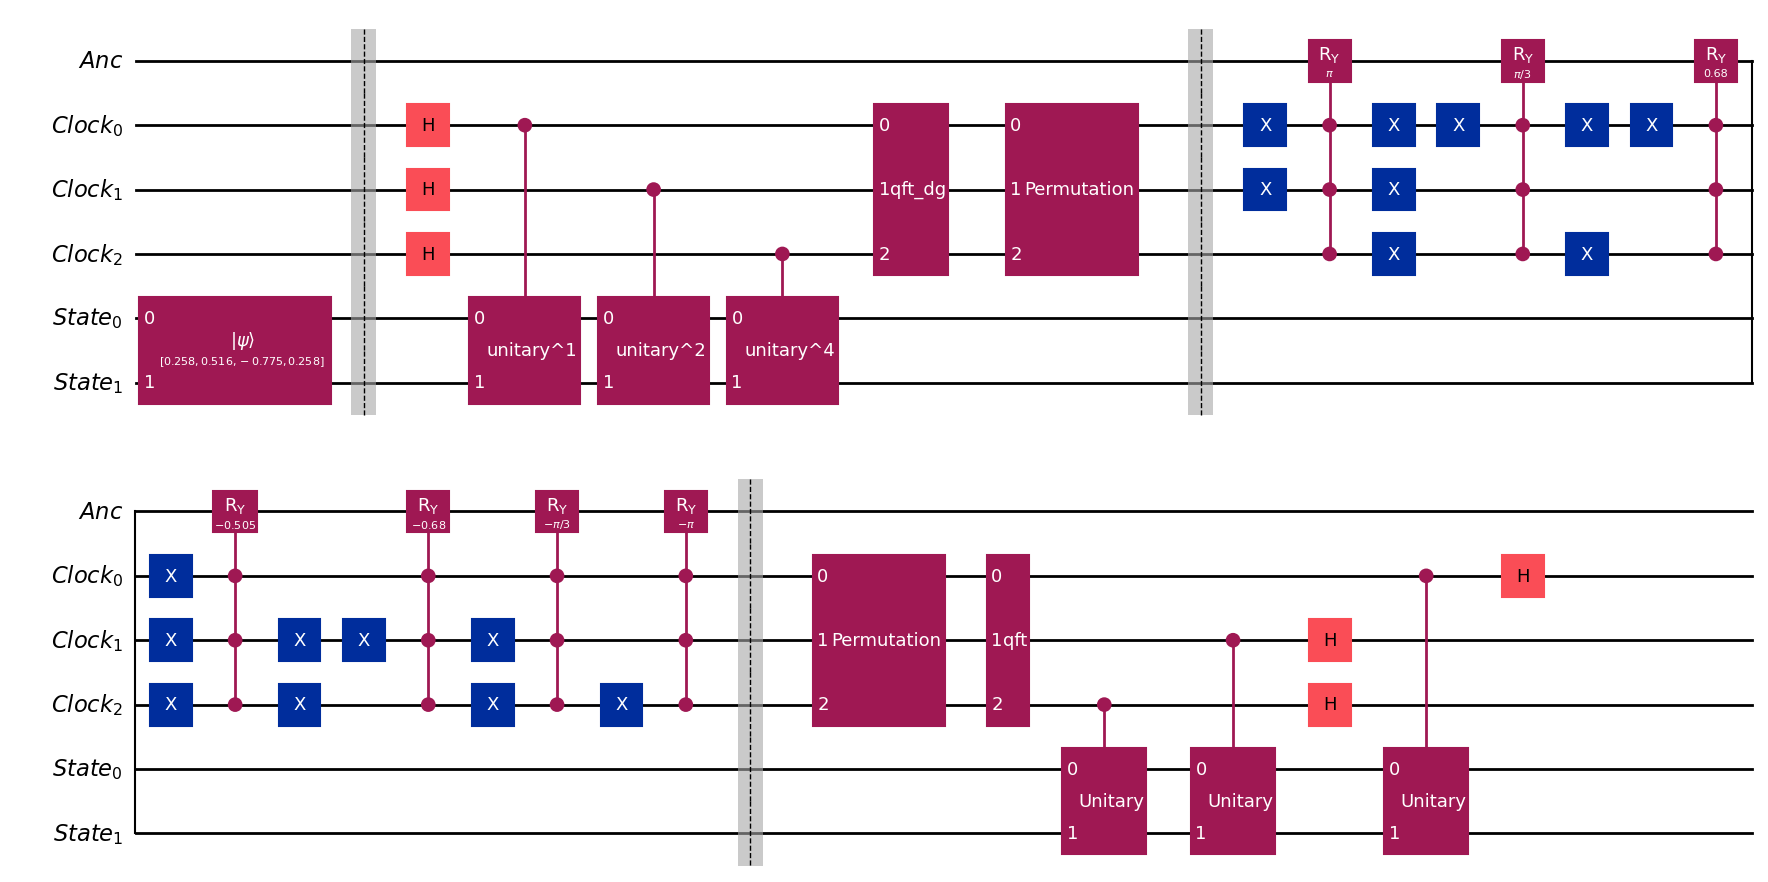

In [4]:
m = 3
t = 1
C = 1
b = np.array([1,2,-3,1])
A = np.array([[1,0,0,2],
              [0,1,0,0],
              [0,0,1,0],
              [2,0,0,1]])

qc = HHL_circuit(m, b, A, t, C)
qc.draw('mpl')

Añadimos los registros clásicos para las medidas.

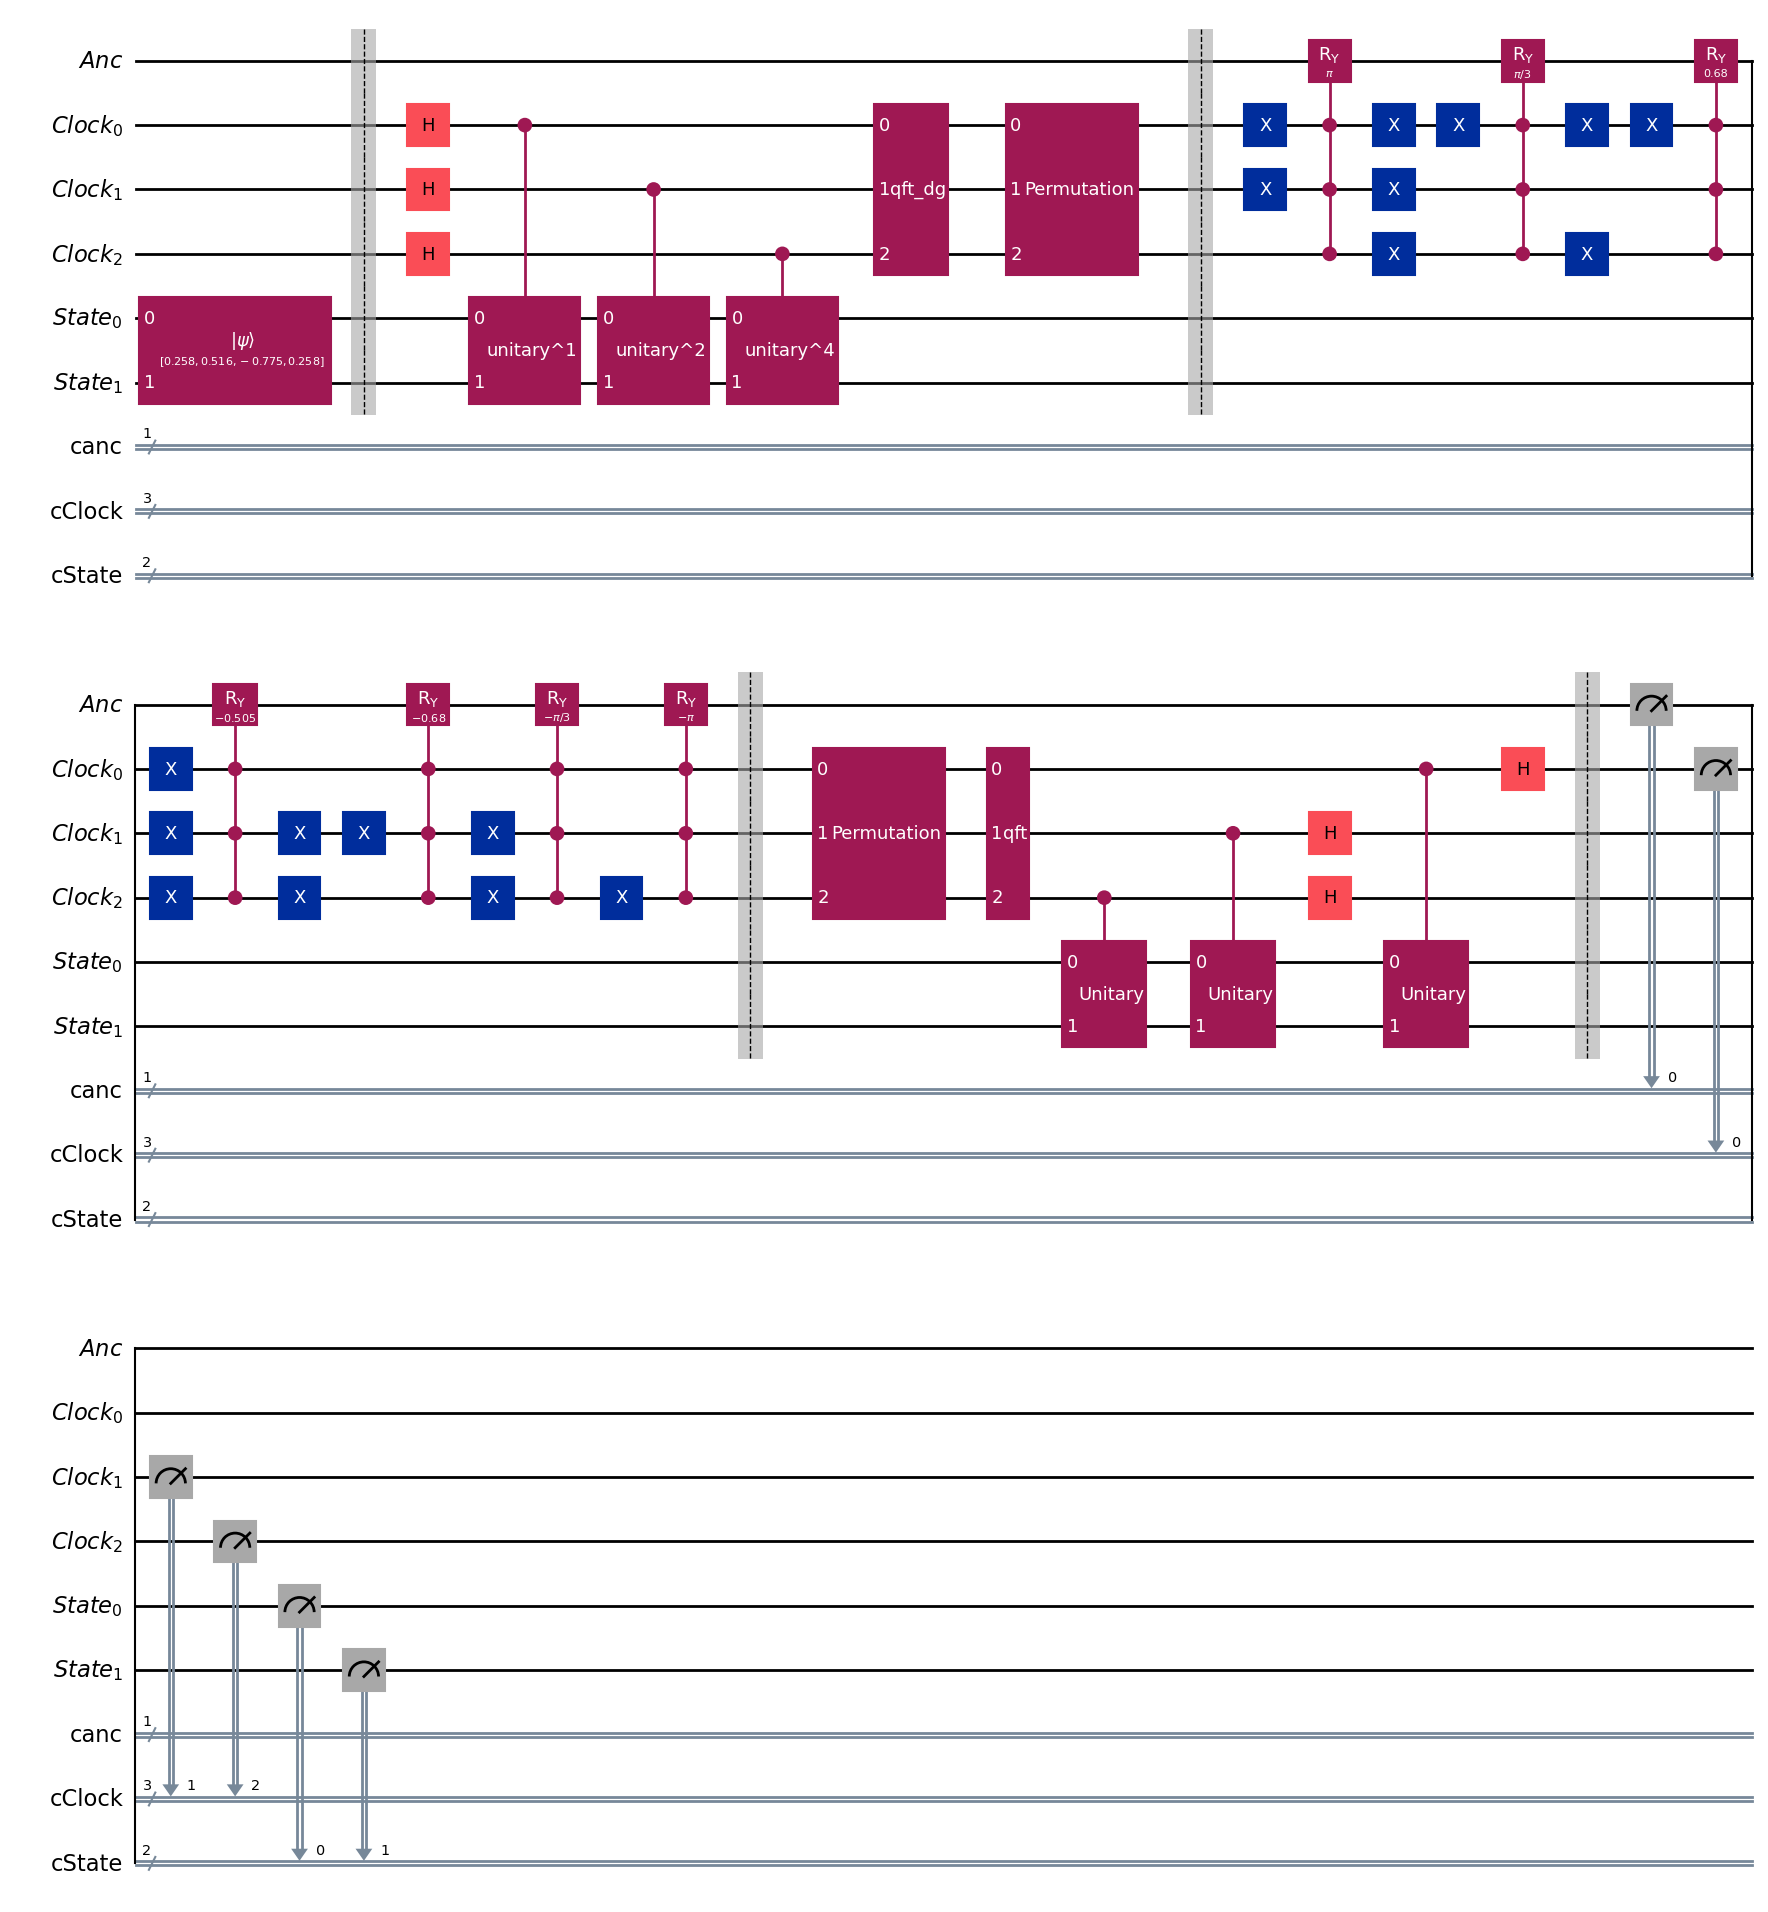

In [5]:
n = int(np.ceil(np.log2(len(b))))
crAncilla = ClassicalRegister(1, name='canc')
crClock = ClassicalRegister(qc.num_qubits-n-1, name='cClock')
crState = ClassicalRegister(n, name='cState')

qc.add_register(crAncilla, crClock, crState)

qc.barrier()
qc.measure(0, crAncilla)
qc.measure(range(1,qc.num_qubits-n), crClock)
qc.measure(range(qc.num_qubits-n,qc.num_qubits), crState)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

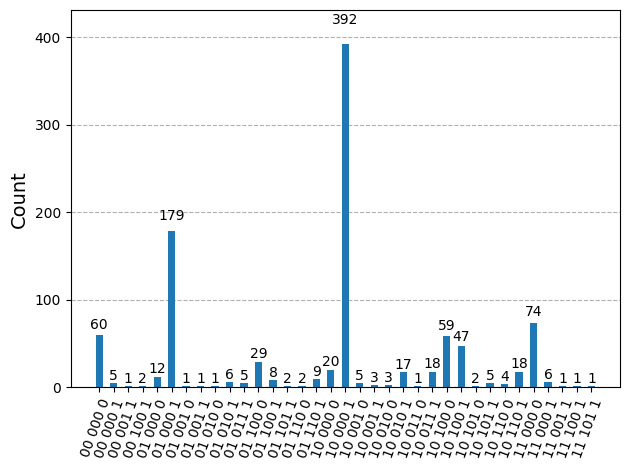

In [6]:
#Número de shots
n_shots = 1000

#Simulador de n+m+1 qubits
backend = AerSimulator()  # qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Calculamos el resultado que deberíamos obtener.

In [7]:
#Cuentas normalizadas para tener quasiprobabilidades para los casos de exito
state_1 = { key[:-2]: counts[key]/(n_shots) for key in counts if key[-1] == '1' }
#Nuevo diccionario para hacer las cuentas marginales (aunque los clock no vuelvan a 0)
x_state = {}
for i in range(2**n):#Empezamos inicializando las claves
    binario = bin(i)[2:]
    binario = '0'*(n-len(binario)) + binario
    x_state[binario] = 0

for i in range(2**n):#Sumamos todos los que cumplan
    binario = bin(i)[2:]
    binario = '0'*(n-len(binario)) + binario
    x_state[binario] += sum([ state_1[key] for key in state_1 if key[:n] == binario ])

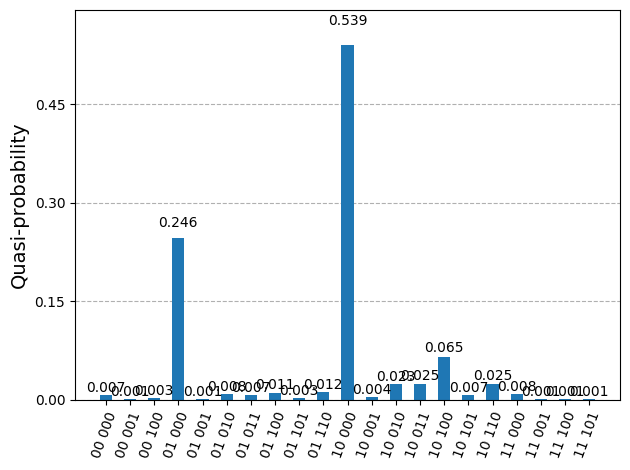

In [8]:
plot_histogram(state_1)

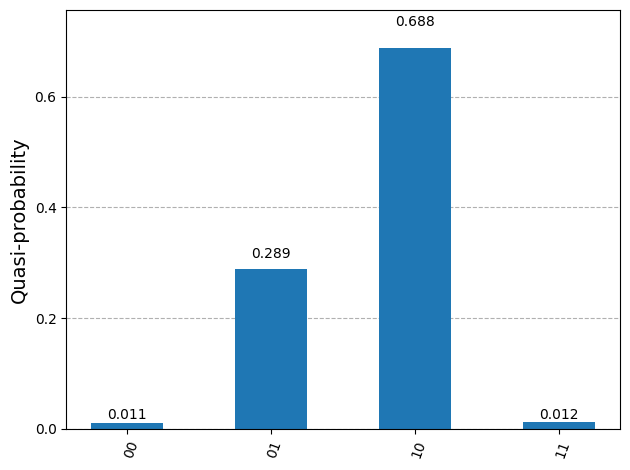

In [9]:
plot_histogram(x_state)

Comparamos con la resolución clásica.

In [10]:
x_real = np.linalg.inv(A)@b
print('Probabilidades que deberíamos obtener: ', (x_real/np.linalg.norm(x_real))**2)# * n_shots)

Probabilidades que deberíamos obtener:  [0.00840336 0.30252101 0.68067227 0.00840336]


---
# Otras pruebas

Vamos a probar con otras matrices y vectores.

---
# Ejercicio

Prueba a introducir una matriz con algún autovalor nulo (por ejemplo, repitiendo una columna o fila), y mira lo que pasa.

---
# Ejercicio

Extiende la función para matrices no hermíticas.

---
# Ejercicio avanzado

Discretiza una ecuación diferencial y resuélvela con el HHL.